## Structured and time series data

This notebook is from a 3rd place winning Kaggle competition as detailed in Guo/Berkhahn's [Entity Embeddings of Categorical Variables](https://arxiv.org/abs/1604.06737).

The motivation behind exploring this architecture is it's relevance to real-world application. Most data used for decision making day-to-day in industry is structured and/or time-series data. Here we explore the end-to-end process of using neural networks with practical structured data problems.

In [136]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [137]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)

PATH= '/fastai/data/rossmann/'

## Create datasets

In addition to the competition data we would be using additional datasets from other participants in the competition.

In [138]:
def concat_csvs(dirname):
    path = f'{PATH}{dirname}'
    filenames = glob(f"{PATH}/*.csv")
    
    wrote_header = False
    with open(f"{path}.csv", w) as outputfile:
        for filename in filenames:
            name = filename.split(".")[0]
            with open(filename) as f:
                line = f.readline()
                if not wrote_header:
                    wrote_header = True
                    outputfile.write("file,"+line)
                for line in f:
                    outputfile.write(name + "," + line)
                outputfile.write("\n")

In [139]:
# concat_csvs('googletrend')
# concat_csvs('weather')

In [140]:
os.listdir(f'{PATH}')

['googletrend.csv',
 'sample_submission.csv',
 'state_names.csv',
 'store.csv',
 'store_states.csv',
 'test.csv',
 'train.csv',
 'weather.csv']

Feature Space:
* train: Training set provided by competition
* store: List of stores
* store_states: mapping of store to German state they are in
* state_names: List of Gernam State names
* googletrend: trend of certain google keywords over time, found by users to correlate well w/ given data
* weather: weather data
* test: testing set

In [141]:
table_names = ['train','store','store_states','state_names','googletrend','weather','test']

We'll be using pandas. pandas allows to manipulate tables/data frames in python as one with relational DBs

Lets load all the csvs as dataframes from the names in list tables


In [142]:
tables = [pd.read_csv(f'{PATH}{fname}.csv',low_memory=False) for fname in table_names]

In [143]:
from IPython.display import HTML,display

 We can use head() to get a quick look at teh contents of each table:
 
 * train: Contains store info on a dialy basis, tracks things like sales, customers, whethere that day was a holiday etc.
 * store: general info about the store including comperition, etc.
 * store_states: maps store to state it is in
 * state_names: maps state abbreviations to names
 * googltrend:  trend data for particular week/state
 * weather: weather conditions for each state
 * test: Same as training table, w/o sales and customers

In [144]:
i = 0
for t in tables:
    display(table_names[i])
    i+=1
    display(t.head())

'train'

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


'store'

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


'store_states'

,Store,State
0,1,HE
1,2,TH
2,3,NW
3,4,BE
4,5,SN


'state_names'

,StateName,State
0,BadenWuerttemberg,BW
1,Bayern,BY
2,Berlin,BE
3,Brandenburg,BB
4,Bremen,HB


'googletrend'

,file,week,trend
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67


'weather'

,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
0,NordrheinWestfalen,2013-01-01,8,4,2,7,5,1,94,87,...,31.0,12.0,4.0,39,26,58.0,5.08,6.0,Rain,215
1,NordrheinWestfalen,2013-01-02,7,4,1,5,3,2,93,85,...,31.0,14.0,10.0,24,16,NaN,0.00,6.0,Rain,225
2,NordrheinWestfalen,2013-01-03,11,8,6,10,8,4,100,93,...,31.0,8.0,2.0,26,21,NaN,1.02,7.0,Rain,240
3,NordrheinWestfalen,2013-01-04,9,9,8,9,9,8,100,94,...,11.0,5.0,2.0,23,14,NaN,0.25,7.0,Rain,263
4,NordrheinWestfalen,2013-01-05,8,8,7,8,7,6,100,94,...,10.0,6.0,3.0,16,10,NaN,0.00,7.0,Rain,268


'test'

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0
3,4,8,4,2015-09-17,1.0,1,0,0
4,5,9,4,2015-09-17,1.0,1,0,0


This is very much like a typical industry dataset.

if you want to check out summarized aggregate information for each table across each field, you can use pandas DataFrameSummary class and summary function

In [145]:
for t in tables: display(DataFrameSummary(t).summary())

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
count,1.01721e+06,1.01721e+06,NaN,1.01721e+06,1.01721e+06,1.01721e+06,1.01721e+06,NaN,1.01721e+06
mean,558.43,3.99834,NaN,5773.82,633.146,0.830107,0.381515,NaN,0.178647
std,321.909,1.99739,NaN,3849.93,464.412,0.375539,0.485759,NaN,0.383056
min,1,1,NaN,0,0,0,0,NaN,0
25%,280,2,NaN,3727,405,1,0,NaN,0
50%,558,4,NaN,5744,609,1,0,NaN,0
75%,838,6,NaN,7856,837,1,1,NaN,0
max,1115,7,NaN,41551,7388,1,1,NaN,1
counts,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209,1017209
uniques,1115,7,942,21734,4086,2,2,4,2


,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
count,1115,NaN,NaN,1112,761,761,1115,571,571,NaN
mean,558,NaN,NaN,5404.9,7.2247,2008.67,0.512108,23.5954,2011.76,NaN
std,322.017,NaN,NaN,7663.17,3.21235,6.19598,0.500078,14.142,1.67494,NaN
min,1,NaN,NaN,20,1,1900,0,1,2009,NaN
25%,279.5,NaN,NaN,717.5,4,2006,0,13,2011,NaN
50%,558,NaN,NaN,2325,8,2010,1,22,2012,NaN
75%,836.5,NaN,NaN,6882.5,10,2013,1,37,2013,NaN
max,1115,NaN,NaN,75860,12,2015,1,50,2015,NaN
counts,1115,1115,1115,1112,761,761,1115,571,571,571
uniques,1115,4,3,654,12,23,2,24,7,3


,Store,State
count,1115,NaN
mean,558,NaN
std,322.017,NaN
min,1,NaN
25%,279.5,NaN
50%,558,NaN
75%,836.5,NaN
max,1115,NaN
counts,1115,1115
uniques,1115,12


,StateName,State
count,16,16
unique,16,16
top,Hessen,SH
freq,1,1
counts,16,16
uniques,16,16
missing,0,0
missing_perc,0%,0%
types,unique,unique


,file,week,trend
count,NaN,NaN,2072
mean,NaN,NaN,63.8142
std,NaN,NaN,12.6502
min,NaN,NaN,0
25%,NaN,NaN,55
50%,NaN,NaN,64
75%,NaN,NaN,72
max,NaN,NaN,100
counts,2072,2072,2072
uniques,14,148,68


,file,Date,Max_TemperatureC,Mean_TemperatureC,Min_TemperatureC,Dew_PointC,MeanDew_PointC,Min_DewpointC,Max_Humidity,Mean_Humidity,...,Max_VisibilityKm,Mean_VisibilityKm,Min_VisibilitykM,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,Max_Gust_SpeedKm_h,Precipitationmm,CloudCover,Events,WindDirDegrees
count,NaN,NaN,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,NaN,15840
mean,NaN,NaN,14.6441,10.389,6.19899,8.58782,6.20581,3.62614,93.6596,74.2829,...,24.0576,12.2398,7.02516,22.7666,11.9722,48.8643,0.831718,5.55131,NaN,175.897
std,NaN,NaN,8.64601,7.37926,6.52639,6.24478,6.08677,6.12839,7.67853,13.4866,...,8.9768,5.06794,4.9806,8.98862,5.87284,13.027,2.51351,1.68771,NaN,101.589
min,NaN,NaN,-11,-13,-15,-14,-15,-73,44,30,...,0,0,0,3,2,21,0,0,NaN,-1
25%,NaN,NaN,8,4,1,4,2,-1,90.75,65,...,14,10,3,16,8,39,0,5,NaN,80
50%,NaN,NaN,15,11,7,9,7,4,94,76,...,31,11,7,21,11,48,0,6,NaN,202
75%,NaN,NaN,21,16,11,13,11,8,100,85,...,31,14,10,27,14,55,0.25,7,NaN,256
max,NaN,NaN,39,31,24,25,20,19,100,100,...,31,31,31,101,53,111,58.93,8,NaN,360
counts,15840,15840,15840,15840,15840,15840,15840,15840,15840,15840,...,15459,15459,15459,15840,15840,3604,15840,14667,11889,15840
uniques,16,990,51,45,40,40,36,40,53,71,...,24,32,24,44,29,47,41,9,21,362


,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
count,41088,41088,41088,NaN,41077,41088,NaN,41088
mean,20544.5,555.9,3.97917,NaN,0.854322,0.395833,NaN,0.443487
std,11861.2,320.274,2.01548,NaN,0.352787,0.489035,NaN,0.496802
min,1,1,1,NaN,0,0,NaN,0
25%,10272.8,279.75,2,NaN,1,0,NaN,0
50%,20544.5,553.5,4,NaN,1,0,NaN,0
75%,30816.2,832.25,6,NaN,1,1,NaN,1
max,41088,1115,7,NaN,1,1,NaN,1
counts,41088,41088,41088,41088,41077,41088,41088,41088
uniques,41088,856,7,48,2,2,2,2


## Data Cleaning / Feature Engineering

This is a structured data problem, so we need to do some data cleaning and feature engineering even though we would be using Neural networks

In [146]:
#assign names to different tables tables list gets split into different named variables as individual tables
train, store, store_states, state_names, googletrend, weather, test = tables

In [147]:
#lets find the length of the tables
len(train), len(test)

(1017209, 41088)

Convert State holidays to boolean to make them convenient for modeling. For this we use pandaas field notations kinda like numpy

In [148]:
train.StateHoliday =  train.StateHoliday!='0'
test.StateHoliday =  test.StateHoliday!='0'

join_df is a function for joining tables on specific fields. By default we will do a left outer join of right on left argument using the given fields for each table

Pandas does joins using the merge method. The suffixes argument describes the naming convention for duplicate fields. We've elected to leave the duplicate fields names on the left untouched and apped a "_y" for those on the right

In [149]:
def join_df(left, right, left_on, right_on=None,suffix='_y'):
    if right_on == None: right_on = left_on
    return left.merge(right, how="left",left_on=left_on, right_on=right_on, suffixes=("",suffix))

Join weather and state_names

In [150]:
weather = join_df(weather,state_names,'file','StateName')

In pandas you can add new columns to a dataframe by simply defininig it. We'll do this for googletrends by extracting dates and state names from the given data and adding those columns.

We're also going to replace all instances of state name NI with "HB,NI" to match the usage in rest of  the data. Pandas also does indexing. We can use .loc[rows,cols] to select a list of rows and a list of columns from the dataframe. IN this case we are selecting rows with statename 'NI' by using boolean list googletrend.State='NI' and selecting 'State'

In [151]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_',expand=True)[2]
googletrend.loc[googletrend.State=='NI','State'] = 'HB,NI'

The following extracts date fields from a complete datetime for the purpose of constructing categoricals.

expanding datetime into these additional fields helps capturing trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table a Date field

In [152]:
add_datepart(weather, "Date",drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

googletrend has a special category for whole of Germany. lets extract it to use explicitly

In [153]:
trend_de =  googletrend[googletrend.file == "Rossmann_DE"]

Now we can outer join all of our data into a single dataframe. Recall that in outer joins everytime a value in the joining field on the left table does not have a corresponding value on the right table, the corresponding row in the new table has Null values for all right table fields. One way to check that all records are consistent and complete is to check for Null values post-join, as we do here.

Aside: Why note just do an inner join? If you are assuming that all records are complete and match on the field you desire, an inner join will do the same thing as an outer join. However, in the event you are wrong or a mistake is made, an outer join followed by a null-check will catch it. (Comparing before/after # of rows for inner join is equivalent, but requires keeping track of before/after row #'s. Outer join is easier.)

In [100]:
#store = tables[1] #reset store after too many join execution

In [154]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [155]:
store = join_df(store,store_states,"Store")
len(store[store.State.isnull()]) #check for nulls

0

In [156]:
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,HE
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,BE
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,SN


In [157]:
len(store.columns)

11

In [158]:
train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,31,4,212,True,False,False,False,False,False,1438300800


In [159]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]), len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [160]:
joined.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,State
0,1,5,2015-07-31,5263,555,1,1,False,1,2015,...,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,HE
1,2,5,2015-07-31,6064,625,1,1,False,1,2015,...,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",TH
2,3,5,2015-07-31,8314,821,1,1,False,1,2015,...,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",NW
3,4,5,2015-07-31,13995,1498,1,1,False,1,2015,...,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,BE
4,5,5,2015-07-31,4822,559,1,1,False,1,2015,...,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,SN


In [161]:
googletrend.head()

,file,week,trend,Date,State,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,Rossmann_DE_SN,2012-12-02 - 2012-12-08,96,2012-12-02,SN,2012,12,48,2,6,337,False,False,False,False,False,False,1354406400
1,Rossmann_DE_SN,2012-12-09 - 2012-12-15,95,2012-12-09,SN,2012,12,49,9,6,344,False,False,False,False,False,False,1355011200
2,Rossmann_DE_SN,2012-12-16 - 2012-12-22,91,2012-12-16,SN,2012,12,50,16,6,351,False,False,False,False,False,False,1355616000
3,Rossmann_DE_SN,2012-12-23 - 2012-12-29,48,2012-12-23,SN,2012,12,51,23,6,358,False,False,False,False,False,False,1356220800
4,Rossmann_DE_SN,2012-12-30 - 2013-01-05,67,2012-12-30,SN,2012,12,52,30,6,365,False,False,False,False,False,False,1356825600


In [162]:
joined = join_df(joined, googletrend, ["State","Year","Week"])
joined_test = join_df(joined_test,googletrend,["State","Year","Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [164]:
joined = join_df(joined,trend_de, ["Year","Week"],suffix='_DE')
joined_test = join_df(joined_test, trend_de, ["Year","Week"],suffix='_DE')
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [165]:
joined = join_df(joined,weather,["State","Date"])
joined_test = join_df(joined_test, weather, ["State", "Date"])


In [166]:
len(joined[joined.Mean_TemperatureC.isnull()]), len(joined_test[joined_test.Max_TemperatureC.isnull()])

(0, 0)

drop all the _y columns which are duplicates

In [168]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c,inplace=True,axis=1)

Next we'll fill in missing values to avoid complications with NA's. NA (not available) is how Pandas indicates missing values; many models have problems when missing values are present, so it's always important to think about how to deal with them. In these cases, we are picking an arbitrary signal value that doesn't otherwise appear in the data.

In [169]:
for df in (joined,joined_test):
    df.CompetitionOpenSinceYear = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df.CompetitionOpenSinceMonth = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df.Promo2SinceYear =  df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df.Promo2SinceWeek = df.Promo2SinceWeek.fillna(1).astype(np.int32)

Next we'll extract features "CompetitionOpenSince" and "CompetitionDaysOpen". Note the use of apply() in mapping a function across dataframe values.

In [170]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear,
                                                    month=df.CompetitionOpenSinceMonth,
                                                    day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

Next we replace some erroneous/outlier data

In [171]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen <0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear < 1990, "CompetitionDaysOpen"] = 0

We can add a column Competition Months Open and limit the max to 2 years to limit number of unique categories

In [172]:
for df in (joined,joined_test):
    df['CompetitionMonthsOpen'] = df.CompetitionDaysOpen //30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] =24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,  1, 14, 20,  8, 18,  6, 21,  5])

Same process for Promo dates

In [174]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: Week(
                                    x.Promo2SinceYear,x.Promo2SinceWeek).monday(), axis=1).astype(pd.datetime))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [175]:
for df in (joined, joined_test):
    df.loc[df.Promo2Days <0, "Promo2Days"]=0
    df.loc[df.Promo2SinceYear < 1990, "Promo2Days"] = 0
    df["Promo2Weeks"]= df.Promo2Days //7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"]=0
    df.loc[df.Promo2Weeks> 25, "Promo2Weeks"]=25

In [176]:
for df in (joined, joined_test):
    df.Promo2Weeks.unique()

Next we dump the dataFrame in feather format

In [177]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

## Durations

It is common with TS Data that relationship across rows is needed as do columns. Those are 

* Running averages
* Time until next event
* Time since last event

we will define a get_elapsed function to cumulatively count rows until a fld is seen again and then its reset


In [179]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1,'D')
    last_date = np.datetime64()
    last_store = 0
    res = []
    
    for s,v,d in zip(df.Store.values, df[fld].values, df.Date.values):
        if s!= last_store:
            last_date =  np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]')/ day1))
    df[pre+fld] = res

We will be applying this to a subset of columns

In [184]:
columns = ["Date","Store","Promo","StateHoliday","SchoolHoliday"]

In [186]:
df = train[columns].append(test[columns])

Lets walk through an Example.

Say we're looking at School Holiday. We'll first sort by Store, then Date, and then call get_elapsed('SchoolHoliday', 'After'): This will apply to each row with School Holiday:

* A applied to every row of the dataframe in order of store and date
* Will add to the dataframe the days since seeing a School Holiday
* If we sort in the other direction, this will count the days until another holiday.

In [188]:
fld = "SchoolHoliday"
df = df.sort_values(["Store","Date"])
get_elapsed(fld,"After")
df = df.sort_values(["Store", "Date"], ascending=[True,False])
get_elapsed(fld, "Before")

We will do this for 2 more fields

In [189]:
fld = "StateHoliday"
df = df.sort_values(["Store", "Date"])
get_elapsed(fld,'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld,'Before')

In [190]:
fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

We are going to set the active index to Date

In [191]:
df = df.set_index("Date")

Then set null values from elapsed field calculations to 0.

In [192]:
columns = ["SchoolHoliday", "StateHoliday", "Promo"]

In [194]:
for o in ["Before", "After"]:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

Next we'll demonstrate window functions in pandas to calculate rolling quantities.

Here we're sorting by date (`sort_index()`) and counting the number of events of interest (`sum()`) defined in `columns` in the following week (`rolling()`), grouped by Store (`groupby()`). We do the same in the opposite direction.

In [195]:
bwd =  df[["Store"]+columns].sort_index().groupby("Store").rolling(7,min_periods=1).sum()
fwd =  df[["Store"]+columns].sort_index(ascending=False).groupby("Store").rolling(7,min_periods=1).sum()

Next we want to drop the Store indices grouped together in the window function

Often in pandas this can be done in place, this is time and memory efficient for large data sets

In [196]:
bwd.drop("Store",1,inplace=True)
bwd.reset_index(inplace=True)

In [197]:
fwd.drop("Store", 1, inplace=True)
fwd.reset_index(inplace=True)

In [198]:
df.reset_index(inplace=True)

Now we will merge values into df

In [199]:
df = df.merge(bwd,'left',['Date','Store'], suffixes=['','_bw'])
df = df.merge(fwd,'left',['Date','Store'], suffixes=['','_fw'])

In [200]:
df.drop(columns, 1, inplace=True)

In [201]:
df.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday,BeforeStateHoliday,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_fw,Promo_fw
0,2015-09-17,1,13,0,105,0,0,0,0.0,0.0,4.0,0.0,0.0,1.0
1,2015-09-16,1,12,0,104,0,0,0,0.0,0.0,3.0,0.0,0.0,2.0
2,2015-09-15,1,11,0,103,0,0,0,0.0,0.0,2.0,0.0,0.0,3.0
3,2015-09-14,1,10,0,102,0,0,0,0.0,0.0,1.0,0.0,0.0,4.0
4,2015-09-13,1,9,0,101,0,9,-1,0.0,0.0,0.0,0.0,0.0,4.0


Its a good practice to save/backup extracted/wrangled features before joining them into the another one, this was you can change that again if needed

In [202]:
df.to_feather(f'{PATH}df')

In [206]:
df = pd.read_feather(f'{PATH}df')

/opt/conda/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [207]:
df["Date"] = pd.to_datetime(df.Date)

In [208]:
df.columns

Index(['Date', 'Store', 'AfterSchoolHoliday', 'BeforeSchoolHoliday',
       'AfterStateHoliday', 'BeforeStateHoliday', 'AfterPromo', 'BeforePromo',
       'SchoolHoliday_bw', 'StateHoliday_bw', 'Promo_bw', 'SchoolHoliday_fw',
       'StateHoliday_fw', 'Promo_fw'],
      dtype='object')

join the new df

In [210]:
joined = join_df(joined,df,['Store','Date'])
joined_test = join_df(joined_test,df, ["Store","Date"])

The authors also removed all instances where the store had zero sale / was closed. We speculate that this may have cost them a higher standing in the competition. One reason this may be the case is that a little exploratory data analysis reveals that there are often periods where stores are closed, typically for refurbishment. Before and after these periods, there are naturally spikes in sales that one might expect. By ommitting this data from their training, the authors gave up the ability to leverage information about these periods to predict this otherwise volatile behavior.

We will back this up too

In [211]:
joined = joined[joined.Sales!=0]

In [212]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [213]:
joined.to_feather(f'{PATH}joined')
joined_test.to_feather(f'{PATH}joined_test')

We now have our final set of engineered features.

While these steps were explicitly outlined in the paper, these are all fairly typical feature engineering steps for dealing with time series data and are practical in any similar setting.

## Create Features

In [373]:
joined = pd.read_feather(f'{PATH}joined')
joined_test = pd.read_feather(f'{PATH}joined_test')

/opt/conda/envs/fastai/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [374]:
joined.head().T.head(40)

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
Customers,555,625,821,1498,559
Open,1,1,1,1,1
Promo,1,1,1,1,1
StateHoliday,False,False,False,False,False
SchoolHoliday,1,1,1,1,1


Now that we've engineered all our features, we need to convert to input compatible with a neural network.

This includes converting categorical variables into contiguous integers or one-hot encodings, normalizing continuous features to standard normal, etc...

Lets define categorical and continous variables

In [375]:
cat_vars = ['Store','DayOfWeek','Year','Month','Day','StateHoliday','CompetitionMonthsOpen','Promo2Weeks',
       'StoreType','Assortment','PromoInterval','CompetitionOpenSinceYear','Promo2SinceYear','State',
       'Week','Events','Promo_fw','Promo_bw','StateHoliday_fw','StateHoliday_bw','SchoolHoliday_fw','SchoolHoliday_bw']
contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); n

844338

In [376]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep,'Date']].copy()

In [377]:
joined_test[dep]= 0
joined_test = joined_test[cat_vars+contin_vars+[dep,'Date','Id']].copy()

In [378]:
for v in cat_vars: joined[v] = joined[v].astype('category').cat.as_ordered()

In [379]:
apply_cats(joined_test, joined)

In [380]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

Lets try and run a sample, we use the same cross validation idxs method which gets a percentent of training data, in this case about 150K out of 90K rows. we then set index as Date since this is time series data

In [255]:
idxs = get_cv_idxs(n,val_pct=150000/n)
joined_samp =  joined.iloc[idxs].set_index("Date")
samp_size = len(joined_samp); samp_size

150000

To run on full dataset, use this lines of code

In [381]:
#comment below lines for first sample run
samp_size = n
joined_samp = joined.set_index('Date')

Lets process our data

In [382]:
joined_samp. head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday,Sales
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,2015,7,31,False,24,0,c,a,...,24.0,11.0,1.0,85.0,83.0,57.0,0.0,1.0,1.0,5263
2015-07-31,2,5,2015,7,31,False,24,25,a,a,...,14.0,11.0,4.0,80.0,83.0,67.0,0.0,1.0,1.0,6064


processdf is a fastai function to take a sample dataframe , remove dependant variable and store in y , return the dataframe and y, it also fills all nulls and returns the columns which were filled with nulls and their media in a dictionary, this can be applied to test data later, if scaling is applied, it adjusts continouse variable data to scale from 0 to 1 or -1 to 1 based on mean and std deviation which is preferred by neural networks for matrix multilpication.

In [383]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y) # YL is log of y the dependant variable

In [384]:
#lets test some of these variables returned from processdf

df.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-07-31,1,5,3,7,31,1,25,1,3,1,...,-1.620066,0.149027,-0.142774,-1.844823,1.732492,1.724334,0.604461,1.13112,1.113717,2.04105
2015-07-31,2,5,3,7,31,1,25,26,1,1,...,-1.264031,-0.960613,-0.142774,-0.488722,1.294578,1.724334,0.926957,1.13112,1.113717,2.04105


the df returned after processing has all numeric columns, categorical variables are converted to 1 to n where n is cardinality of the variable. Some variables have an additional value to hold unknown as in day of week becomes 8, 7+1  for unknown. Say for example StoreType a,c becomes 1,3.

Continous Variables are scaled. For example Max_Wind_SpeedKm_h values 18.0 and 29.0 become -0.651394 and 0.700532

Sales column is removed from the df

In [385]:
y #printing y which is the dependant variable sales removed from df

array([ 5263,  6064,  8314, 13995,  4822,  5651, 15344,  8492,  8565,  7185, 10457,  8959,  8821,  6544,
        9191, 10231,  8430, 10071,  8234,  9593, ...,  6218, 20642,  3697,  4220,  6851, 17267,  3102,  2401,
        3139,  9643,  3113,  2646,  2907,  8498,  3821,  3375, 10765,  5035,  4491,  5961])

In [386]:
#df['Sales'] would result in a keyError
#test nas
nas

{}

nas is empty in this case

In [387]:
#test mapper
mapper

DataFrameMapper(default=False, df_out=False,
        features=[(['CompetitionDistance'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['Max_TemperatureC'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['Mean_TemperatureC'], StandardScaler(copy=True, with_mean=True, with_std=True)), (['Min_TemperatureC'], StandardScaler(co...rue, with_std=True)), (['SchoolHoliday'], StandardScaler(copy=True, with_mean=True, with_std=True))],
        input_df=False, sparse=False)

mapper stores the continous variables which were scaled and the type of scaling applied. This would help in test time scaling

We do the same for test data as we did for training data, set index, process data frame, in this case we skip ID field and pass the mapper obtained from training scaling of continous variables so same scaling can be done for test data too, we also pass the nas obtained from process training data 

In [388]:
joined_test = joined_test.set_index('Date')

In [389]:
df_test,_,nas,mapper  = proc_df(joined_test,'Sales',do_scale=True,skip_flds=['Id'],mapper=mapper,na_dict=nas)

In [390]:
df_test.head(2)

,Store,DayOfWeek,Year,Month,Day,StateHoliday,CompetitionMonthsOpen,Promo2Weeks,StoreType,Assortment,...,Min_Humidity,Max_Wind_SpeedKm_h,Mean_Wind_SpeedKm_h,CloudCover,trend,trend_DE,AfterStateHoliday,BeforeStateHoliday,Promo,SchoolHoliday
Date,,,,,,,,,,,,,,,,,,,,,
2015-09-17,1,4,3,9,17,1,25,1,3,1,...,1.940282,0.703847,0.362855,0.415345,0.331166,0.078057,2.152443,1.13112,1.113717,-0.489944
2015-09-17,3,4,3,9,17,1,25,26,1,1,...,0.414418,1.591558,2.385369,0.415345,0.243584,0.078057,2.152443,1.13112,1.113717,-0.489944


In [391]:
# we skip the returned y/saled column here, lets test it: 
#It returns 0 since test data does not have sales or dependant variable
_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0])

In time series data, cross-validation is not random. Instead, our holdout data is generally the most recent data, as it would be in real application. This issue is discussed in detail in [this post](http://www.fast.ai/2017/11/13/validation-sets/) on our web site.

One approach is to take the last 25% of rows (sorted by date) as our validation set.

In [392]:
train_ratio = 0.75
train_size = int(samp_size* train_ratio)
val_idx = list(range(train_size, len(df)))

An even better option for picking a validation set is using the exact same length of time period as the test set uses this is implemented as follows. in this case from the test data August 1 to Sep 17 2014 is used

In [393]:
val_idx = np.flatnonzero(
    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [394]:
#we will be using this val_idx with date range so its not reset to 0, that line is commented
#val_idx=[0]
val_idx

array([277141, 277142, 277143, 277144, 277145, 277146, 277147, 277148, 277149, 277150, 277151, 277152,
       277153, 277154, 277155, 277156, 277157, 277158, 277159, 277160, ..., 315520, 315521, 315522, 315523,
       315524, 315525, 315526, 315527, 315528, 315529, 315530, 315531, 315532, 315533, 315534, 315535,
       315536, 315537, 315538, 315539])


## DL


We are ready to create our models.
Root-mean-squared percent error is the metric Kaggle used for this competition

In [395]:
def inv_y(a): return np.exp(a) # method to apply exp of y

def exp_rmspe(y_pred, targ): # root mean squared percent error calculation method
    targ = inv_y(targ) # targ is exp
    pct_var = (targ - inv_y(y_pred))/ targ #percent of loss/error
    return math.sqrt((pct_var**2).mean()) # root mean square of above

max_log_y = np.max(yl) #calculate max of log of y
y_range =  (0, max_log_y*1.2) #set y range from 0 to max log*1.2

In [396]:
#we create model from data frame unlike other use cases where we pass data to the model
md =  ColumnarModelData.from_data_frame(PATH,val_idx,df,yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

In [296]:
# since we wrongly names yL as y1 we rest y1 to none to avoid any bugs
#y1 = None

Some categorical variables have a lot more levels than others. Store, in particular, has over a thousand!. Next up we create embeddings for categorical variables. for this we create cat_sz which holds the categories and their cardinality ( different types of values in variable, say DayOfWeek as 7 types of days). Note that we use joined_samp as df already has this applied. We also add a 1 to cardinality for unknown type

In [397]:
cat_sz = [(c,len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [398]:
cat_sz

[('Store', 1116),
 ('DayOfWeek', 8),
 ('Year', 4),
 ('Month', 13),
 ('Day', 32),
 ('StateHoliday', 3),
 ('CompetitionMonthsOpen', 26),
 ('Promo2Weeks', 27),
 ('StoreType', 5),
 ('Assortment', 4),
 ('PromoInterval', 4),
 ('CompetitionOpenSinceYear', 24),
 ('Promo2SinceYear', 9),
 ('State', 13),
 ('Week', 53),
 ('Events', 22),
 ('Promo_fw', 7),
 ('Promo_bw', 7),
 ('StateHoliday_fw', 4),
 ('StateHoliday_bw', 4),
 ('SchoolHoliday_fw', 9),
 ('SchoolHoliday_bw', 9)]

We use the cardinality of each variable (that is, its number of unique values) to decide how large to make its embeddings. Each level will be associated with a vector with length defined as below. To define embedding size the categories cardinality is divided by 2 and capped at a max of 50

In [399]:
emb_szs = [(c, min(50,(c+1)//2)) for _,c in cat_sz]

In [400]:
emb_szs

[(1116, 50),
 (8, 4),
 (4, 2),
 (13, 7),
 (32, 16),
 (3, 2),
 (26, 13),
 (27, 14),
 (5, 3),
 (4, 2),
 (4, 2),
 (24, 12),
 (9, 5),
 (13, 7),
 (53, 27),
 (22, 11),
 (7, 4),
 (7, 4),
 (4, 2),
 (4, 2),
 (9, 5),
 (9, 5)]

In [401]:
# we get the learner from the model
# we pass the embedding sizes for categorical variables, the number of continous variables in data (total - cats)
# drop out prob for embedding matrix in training
# size of output 1 since only Sales is predicted
# size of intermediate layers and their drop out percentage
# yrange calculated above
m = md.get_learner(emb_szs,len(df.columns) - len(cat_vars),
                  0.04, 1, [1000,500], [0.001, 0.01], y_range=y_range)

m.summary()

OrderedDict([('Embedding-1',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 50]),
                           ('trainable', True),
                           ('nb_params', 55800)])),
             ('Embedding-2',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 4]),
                           ('trainable', True),
                           ('nb_params', 32)])),
             ('Embedding-3',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 2]),
                           ('trainable', True),
                           ('nb_params', 8)])),
             ('Embedding-4',
              OrderedDict([('input_shape', [-1]),
                           ('output_shape', [-1, 7]),
                           ('trainable', True),
                           ('nb_params', 91)])),
             ('Embedding-5',
              OrderedDict([('input_shape', [-1])

In [302]:
#we set learning rate to 0.001 and try finding a learning rate
# note the run stops when it finds a good rate ;)
lr = 1e-3
m.lr_find()

 63%|██████▎   | 711/1120 [00:11<00:06, 64.27it/s, loss=0.173] 

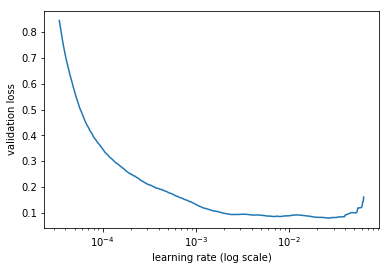

In [304]:
m.sched.plot(100)

we plot the schedule and find that at 1e-2 the loss stabilizes, so a learning rate above that which is 1e-3 is good

## Sample

Start training with some changes in hyper parameters and see how it fits. Along with learnig rate and cycle length we also pass a metrics column that would be calculated for each training batch run using the method name exp_rmspe which was defined above. This allows for tracking the rmspe while training.
Cycle len in this case without SGDR means number of epochs(epoch =  one full traversal of entire training set divided into number of batches as set in batch size, for each batch loss is calculated, learning rate adjusted down using cosine annealing, back propagation done on weights etc.) For SGDR with cycle mult value set, after each cycle the number of epochs is multiplied so 1,2,4 epochs each for 3 cycles total 7 epochs. For 7 epochs the learning rate jumps back up only twice.

In [306]:
m = md.get_learner(emb_szs,len(df.columns)-len(cat_vars),0.04,1,[1000,500],[0.001,0.01],y_range=y_range)

lr= 1e-3

In [307]:
m.fit(lr,3,metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.02704    0.039115   0.173754  
    1      0.020507   0.022495   0.14024                        
    2      0.016868   0.016398   0.125933                       


[array([0.0164]), 0.12593344541928664]

In [308]:
# lets increase the number of cycles/epochs while keeping cycle_len=1
m.fit(lr,5,metrics=[exp_rmspe],cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.012911   0.019133   0.125824  
    1      0.011554   0.018553   0.124568                       
    2      0.010678   0.017656   0.121415                       
    3      0.010012   0.017464   0.120985                        
    4      0.009236   0.016808   0.119305                        


[array([0.01681]), 0.11930530344497095]

In [309]:
#now keeping the cycles 2, lets increase the cycle_len to 4 which means for each cycle there are 4 epochs
m.fit(lr,2, metrics=[exp_rmspe],cycle_len=4)

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.012051   0.025523   0.143392  
    1      0.009702   0.014658   0.114413                        
    2      0.007993   0.016061   0.117262                        
    3      0.007428   0.014587   0.11319                         
    4      0.010577   0.02167    0.133442                       
    5      0.008243   0.013859   0.112568                        
    6      0.007344   0.013802   0.113474                        
    7      0.006361   0.014215   0.113317                        


[array([0.01422]), 0.11331701608508474]

## All

Now that we have trained on some sample size of 150K lets do for all, we need to go back up to cells where data is loaded from feather again and this time instead of sample 15K set sample size to n and redo all cells as some data may need to be reinitialized

In [402]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                  0.04,1,[1000,500],[0.001,0.01],y_range=y_range)
lr = 1e-3

In [403]:
m.fit(lr,1,metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.015167   0.019224   0.125033  


[array([0.01922]), 0.1250334666268418]

In [404]:
#next 3 cycles(epochs)
m.fit(lr,3,metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.011398   0.013127   0.106816  
    1      0.010106   0.012431   0.105821                        
    2      0.008515   0.012983   0.104717                        


[array([0.01298]), 0.10471671774784977]

In [405]:
m.fit(lr,3,metrics=[exp_rmspe],cycle_len=1)

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.007024   0.010659   0.096697  
    1      0.006628   0.010483   0.095939                        
    2      0.006644   0.010471   0.095873                        


[array([0.01047]), 0.09587348111565544]

## Test

In [406]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                  0.04,1,[1000,500],[0.001,0.01],y_range=y_range)
lr = 1e-3

In [407]:
m.fit(lr,3,metrics=[exp_rmspe])

epoch      trn_loss   val_loss   exp_rmspe                      
    0      0.013226   0.017029   0.11883   
    1      0.010913   0.012722   0.10699                        
    2      0.009402   0.013682   0.107404                        


[array([0.01368]), 0.10740399835864908]

In [408]:
m.fit(lr,2,metrics=[exp_rmspe],cycle_len=4)

epoch      trn_loss   val_loss   exp_rmspe                       
    0      0.008777   0.012264   0.10508   
    1      0.007351   0.01097    0.10065                         
    2      0.0071     0.010824   0.098484                        
    3      0.00614    0.010741   0.097597                        
    4      0.008231   0.011242   0.104283                        
    5      0.006644   0.011975   0.101696                        
    6      0.006046   0.010617   0.096979                        
    7      0.005975   0.01029    0.096155                        


[array([0.01029]), 0.09615504027721979]

In [409]:
#lets save the model
m.save("val0")

In [410]:
m.load("val0")

In [411]:
#lets predict
x,y=m.predict_with_targs()

In [412]:
exp_rmspe(x,y)

0.09958669460365258

In [413]:
pred_test=m.predict(True)

In [414]:
pred_test=np.exp(pred_test)

In [415]:
joined_test['Sales']=pred_test

In [416]:
csv_fn=f'{PATH}tmp/sub.csv'

In [420]:
joined_test[['Id','Sales']].to_csv(csv_fn,index=False)

In [421]:
FileLink(csv_fn)

/fastai/data/rossmann/tmp/sub.csv

## RF

In [422]:
from sklearn.ensemble import RandomForestRegressor

In [423]:
((val,trn),(y_val,y_trn)) = split_by_idx(val_idx,df.values,yl)

In [424]:
m = RandomForestRegressor(n_estimators=40,max_features=0.99,min_samples_leaf=2,n_jobs=-1,oob_score=True)


In [425]:
m.fit(trn,y_trn)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.99, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=40, n_jobs=-1,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [426]:
preds = m.predict(val)
m.score(trn,y_trn), m.score(val,y_val), m.oob_score_,exp_rmspe(preds,y_val)

(0.9822685814361412,
 0.9314587694866898,
 0.9245485327971483,
 0.10891412039399144)